In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Create a really dumb map, and work with it until erosion is complete and satisfactory

In [2]:
"The mysterius Island"

'The mysterius Island'

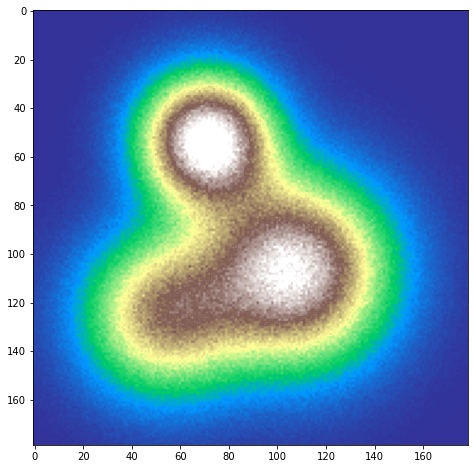

In [3]:
samples1 = np.random.multivariate_normal((6, 6), cov=np.eye(2)*2, size=4000000)
samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2), size=2200000)
samples3 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2, samples3))
bins = np.linspace(0, 10, 180)
bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] * 4

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain, vmin=0, vmax=4000)

making a few diagnostic slices

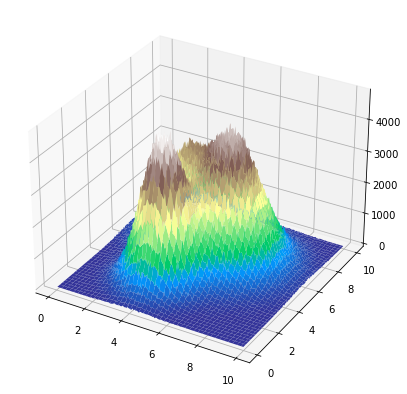

In [4]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)

xx, yy = np.meshgrid(bcens, bcens)
zz = land.flatten()
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7, 7))
ax.plot_surface(xx, yy, land, shade=True, cmap=plt.cm.terrain, )
# ax = plt.axes(projection='3d')
plt.show()

# Flow water down the hill

In [5]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [6]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [7]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, evap_rate=0., rainmap=None):
        """
        This is adds new rain water to the water canvas
        
        Perhaps later this will be a non uniform rainfall pattern, once heat and cold is introduced to 
        account for evaporation
        
        rainmap is the characteristic rainfall pattern
        net rainfall is the amplitude of the rainmap
        """
        self.layers = np.sort(("water",))
        self.key = "water"
               
        self.rainfall = rainfall
        self.evap_rate = evap_rate
        self.rainmap = rainmap
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        if self.rainmap is not None:
            water = self.rainmap * self.rainfall
        else:
            water = np.ones(shape=water_local.shape) * self.rainfall
        water -= self.evap_rate
        water[water < 1e-3] = 0.
            
        water_local += water
#         print(water_local)
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        

        
        
class Landslide(FlowRule):
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        height_local = self.calc_flows(cell, height_local, outflow)
        
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

In [23]:
   
class WaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4):
        """
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.altitude = altitude
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        height_local = rock_local + gravel_local# + self.altitude
        height_shifted = rock_shifted + gravel_shifted# + self.altitude
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # 2) the gravel flows
        gflow_limit = np.array([gravel_local * self.drag_coeff * self.gravel_factor,] * 4) / 4
        outflow_g = outflow_w * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        
        # 3) The rock erodes
        # we have to establish the local gravel coverage
        # The rock is eroded by the flow of water
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        
        # in megaoutflow, water can pile up really high, this must be regularized
#         outflow_l = outflow_w * self.land_coerosion_rate
#         ii = outflow_l > (lflow_limit)
#         outflow_l[ii] = lflow_limit[ii]        
        
#         rock_local -= outflow_l.sum(axis=0)    
        # The land is flown into gravel, not into land
        
#         gflow_limit = np.array([gravel_local * self.drag_coeff * self.gravel_factor,] * 4) / 4
#         outflow_g = outflow_w * self.land_coerosion_rate * self.gravel_factor
#         ii = outflow_g > (gflow_limit)
#         outflow_g[ii] = gflow_limit[ii]
#         gravel_local = self.calc_flows(gravel_local, outflow_g, cell)
#         gravel_local += self._calc_flows(rock_local, outflow_l, cell)
        
        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    

# We are going to set up erosion in burst mode

A gaussian amount of rainfall, centered on the island

Each burst is simulated for a few hundred steps

## First let's map out the lay of rainfall distribution

In [24]:
tmp1 = np.random.multivariate_normal((60, 50), cov=np.eye(2)*200, size=10)
tmp2 = np.random.multivariate_normal((80, 100), cov=np.eye(2)*200, size=10)
tmp2 = np.random.multivariate_normal((100, 120), cov=np.eye(2)*300, size=10)
tmp3 = np.random.multivariate_normal((60, 130), cov=np.eye(2)*200, size=10)
tmp4 = np.random.multivariate_normal((130, 100), cov=np.eye(2)*200, size=10)
tmp5 = np.random.multivariate_normal((80, 80), cov=np.eye(2)*400, size=40)
rain_locs = np.vstack((tmp1, tmp2, tmp3, tmp4, tmp5))
np.random.shuffle(rain_locs)

In [25]:
null_edges(land)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 16., 20., ...,  0.,  0.,  0.],
       [ 0.,  8.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

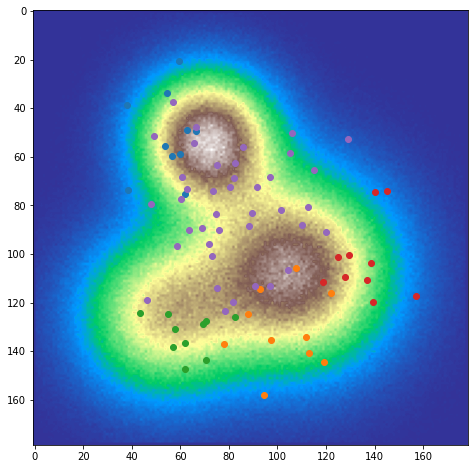

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(land, cmap=plt.cm.terrain, )
ax.scatter(tmp1[:, 0], tmp1[:, 1])
ax.scatter(tmp2[:, 0], tmp2[:, 1])
ax.scatter(tmp3[:, 0], tmp3[:, 1])
ax.scatter(tmp4[:, 0], tmp4[:, 1])
ax.scatter(tmp5[:, 0], tmp5[:, 1])

In [13]:
bins = np.linspace(0, 180, 180)
rainbursts = []
for i, loc in enumerate(rain_locs):
    samples = np.random.multivariate_normal(loc, cov=np.eye(2)*100, size=50000)
    rainburst = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0]
    rainbursts.append(rainburst * 5e6)

# = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] * 3


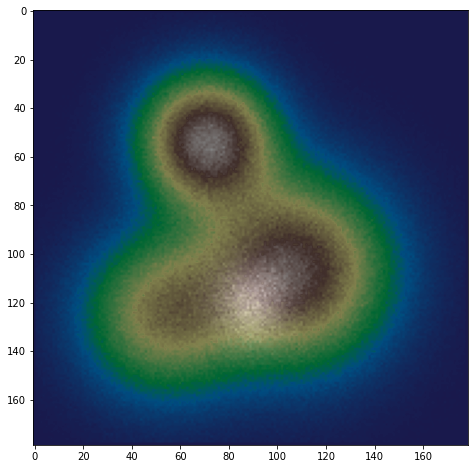

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(land, cmap=plt.cm.terrain, )
ax.imshow(rainbursts[0], alpha=0.5, cmap=plt.cm.gray)

In [26]:
rules = (
    WaterGravelFlow(land_coerosion_rate=0.1, water_flow_rate=0.9, drag_coeff=0.2),
)
wmap = np.zeros(shape=land.shape)
gmap = np.zeros(shape=land.shape)
initial_maps = {
    "rock": null_edges(land * 0.9),
    "gravel": null_edges(land * 0.1),
    "water": null_edges(wmap),
}

In [34]:
all_rock = []
all_gravel = []
all_waters = []
cs = CellSpace(initial_maps, rules)
cs.flow(1, savestep=1)
for i, wmap in enumerate(rainbursts[:1]):
    print(i)
    maps = {
        "rock": copy.deepcopy(cs.maps["rock"][-1]),
        "gravel": copy.deepcopy(cs.maps["gravel"][-1]),
        "water": wmap,
    }
    cs = CellSpace(maps, rules)
    cs.flow(400, savestep=100)
    all_rock.append(copy.deepcopy(cs.maps["rock"]))
    all_gravel.append(copy.deepcopy(cs.maps["gravel"]))
    all_waters.append(copy.deepcopy(cs.maps["water"]))

0 out of 0
0
0 out of 399
1 out of 399
2 out of 399
3 out of 399
4 out of 399
5 out of 399
6 out of 399
7 out of 399
8 out of 399
9 out of 399
10 out of 399
11 out of 399
12 out of 399
13 out of 399
14 out of 399
15 out of 399
16 out of 399
17 out of 399
18 out of 399
19 out of 399
20 out of 399
21 out of 399
22 out of 399
23 out of 399
24 out of 399
25 out of 399
26 out of 399
27 out of 399
28 out of 399
29 out of 399
30 out of 399
31 out of 399
32 out of 399
33 out of 399
34 out of 399
35 out of 399


/tmp/ipykernel_4326/2444478692.py:50: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


36 out of 399
37 out of 399
38 out of 399
39 out of 399
40 out of 399
41 out of 399
42 out of 399
43 out of 399
44 out of 399
45 out of 399
46 out of 399
47 out of 399
48 out of 399
49 out of 399
50 out of 399
51 out of 399
52 out of 399
53 out of 399
54 out of 399
55 out of 399
56 out of 399
57 out of 399
58 out of 399
59 out of 399
60 out of 399
61 out of 399
62 out of 399
63 out of 399
64 out of 399
65 out of 399
66 out of 399
67 out of 399
68 out of 399
69 out of 399
70 out of 399
71 out of 399
72 out of 399
73 out of 399
74 out of 399
75 out of 399
76 out of 399
77 out of 399
78 out of 399
79 out of 399
80 out of 399
81 out of 399
82 out of 399
83 out of 399
84 out of 399
85 out of 399
86 out of 399
87 out of 399
88 out of 399
89 out of 399
90 out of 399
91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 out of 399
101 out of 399
102 out of 399
103 out of 399
104 out of 399
105 out of 399
106 out of 399

In [35]:
rock = np.concatenate(all_rock)
gravel = np.concatenate(all_gravel)
waters = np.concatenate(all_waters)

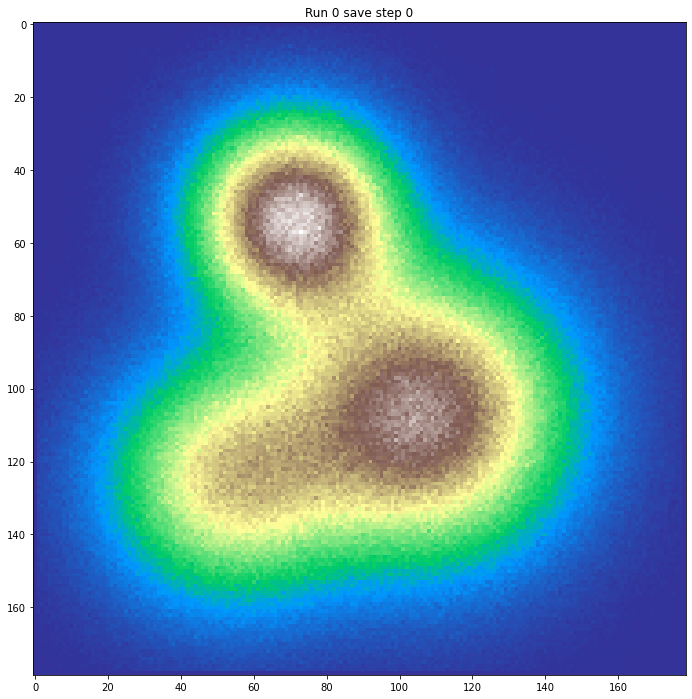

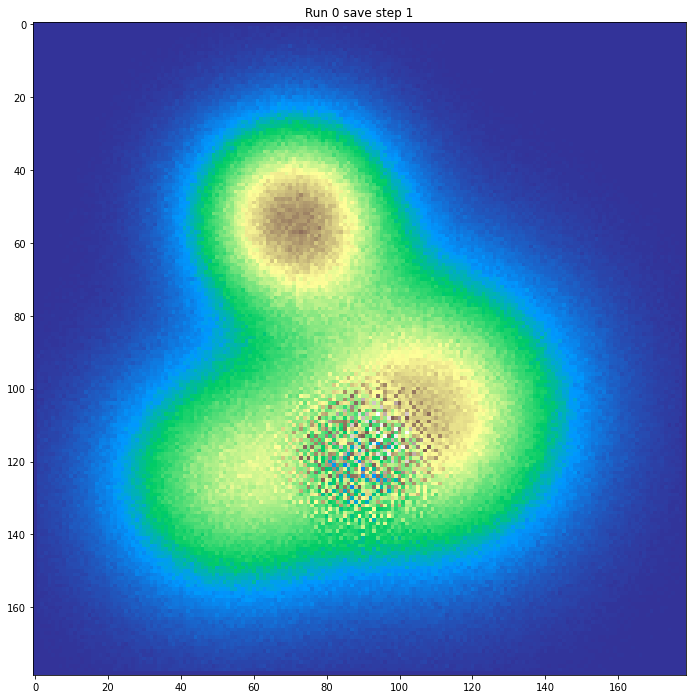

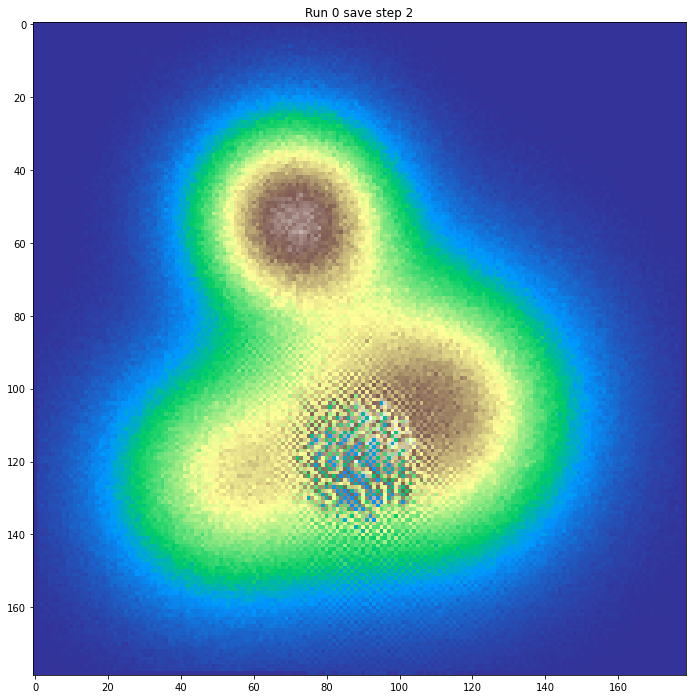

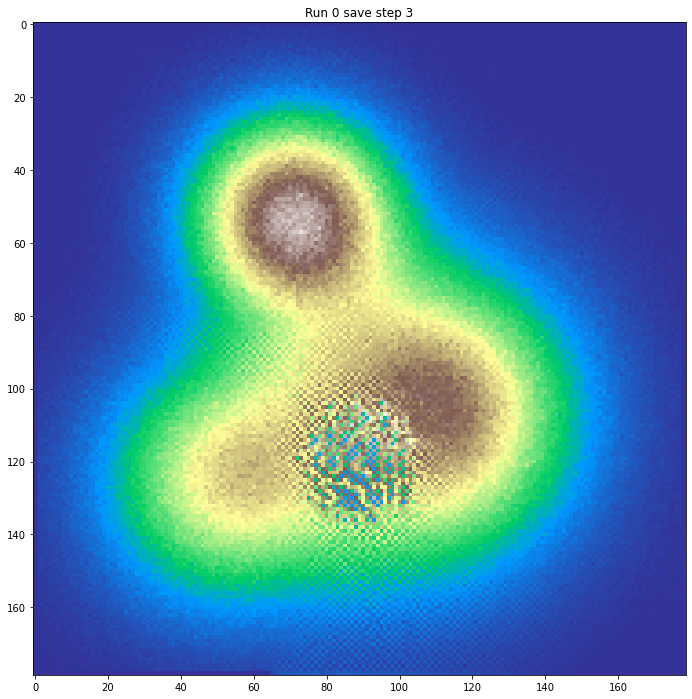

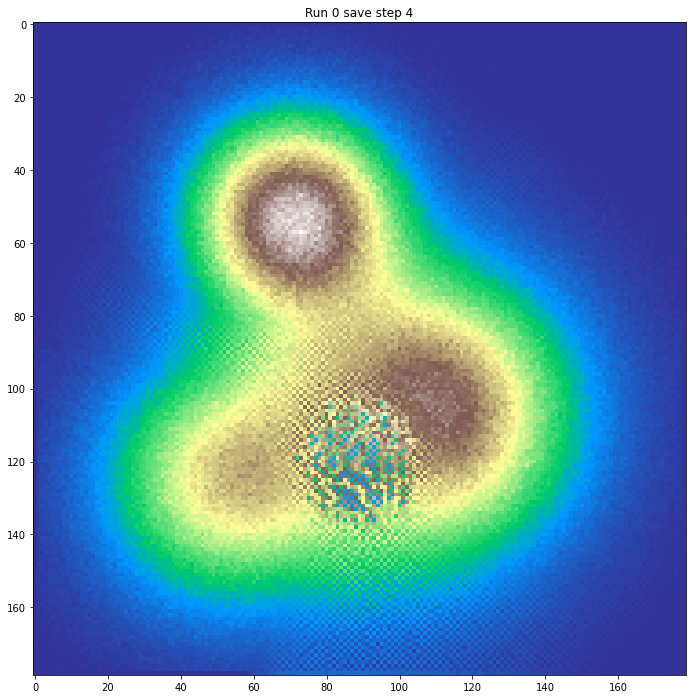

In [36]:
# for j in np.arange(80):
#     for i in (0, 4):
j = 0
for i in np.arange(5):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run " + str(j) + " save step " + str(i)
    ax.set_title(title)
    ax.imshow(all_rock[j][i], cmap=plt.cm.terrain, )
#     alphas = all_waters[j][i] / 10000
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[j][i], cmap=plt.cm.plasma_r, vmin=0, vmax=100, alpha=alphas)

NameError: name 'terrain' is not defined

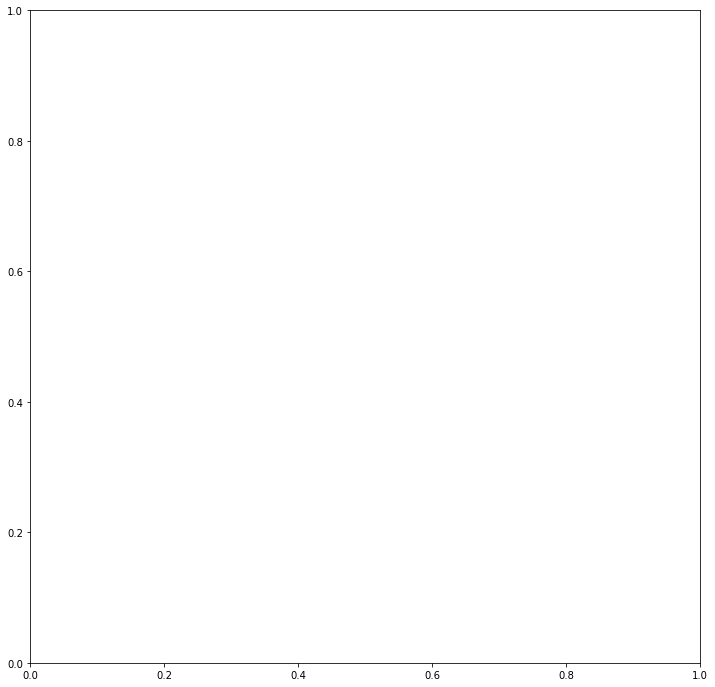

In [85]:
for i in np.arange(10):
# for i in np.ara
#     print(waters[i].max())
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(terrain[i], cmap=plt.cm.terrain, )
#     alpha= (waters[i] > 0).astype(float) * 0.5
#     ax.imshow(waters[i], cmap=plt.cm.gray, vmin=0, vmax=20, alpha=0.5)
#     print(terrain[i].min(), terrain[i].max())
#     print(waters[i].min(), waters[i].max())
#     ax = fig.add_subplot(111)
#     ax.imshow(terrain[i])